In [ ]:
pip install fastdtw

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp312-cp312-linux_x86_64.whl size=567863 sha256=a1c1fbb7fcb97bb8f9bcb6a0e0ea8caa30f51f396545a11e97800186c17c202a
  Stored in directory: /root/.cache/pip/wheels/ab/d0/26/b82cb0f49ae73e5e6bba4e8462fff2c9851d7bd2ec64f8891e
Successfully built fastdtw


In [1]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train = pd.read_csv('/content/drive/MyDrive/국민대_무역_공모전/데이터/train.csv')
submission = pd.read_csv('/content/drive/MyDrive/국민대_무역_공모전/데이터/sample_submission.csv')

In [4]:
monthly = train.groupby(['item_id', 'year', 'month']).agg({
    'value': 'sum',
    'weight': 'sum',
    'quantity': 'sum',
    'hs4': 'first'
}).reset_index()

monthly['year_month'] = pd.to_datetime(
    monthly['year'].astype(str) + '-' + monthly['month'].astype(str),
    format='%Y-%m'
)

pivot_value = monthly.pivot_table(
    index='year_month',
    columns='item_id',
    values='value',
    fill_value=0
).sort_index()

# Transpose: item을 index로 (예시 코드 형식)
pivot = pivot_value.T  # (100 items × 43 months)

pivot.head(5)

year_month,2022-01-01,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,...,2024-10-01,2024-11-01,2024-12-01,2025-01-01,2025-02-01,2025-03-01,2025-04-01,2025-05-01,2025-06-01,2025-07-01
item_id,,,,,,,,,,,,,,,,,,,,,
AANGBULD,14276.0,52347.0,53549.0,0.0,26997.0,84489.0,0.0,0.0,0.0,0.0,...,428725.0,144248.0,26507.0,25691.0,25805.0,0.0,38441.0,0.0,441275.0,533478.0
AHMDUILJ,242705.0,120847.0,197317.0,126142.0,71730.0,149138.0,186617.0,169995.0,140547.0,89292.0,...,123085.0,143451.0,78649.0,125098.0,80404.0,157401.0,115509.0,127473.0,89479.0,101317.0
ANWUJOKX,0.0,0.0,0.0,63580.0,81670.0,26424.0,8470.0,0.0,0.0,80475.0,...,0.0,0.0,0.0,27980.0,0.0,0.0,0.0,0.0,0.0,0.0
APQGTRMF,383999.0,512813.0,217064.0,470398.0,539873.0,582317.0,759980.0,216019.0,537693.0,205326.0,...,683581.0,2147.0,0.0,25013.0,77.0,20741.0,2403.0,3543.0,32430.0,40608.0
ATLDMDBO,143097177.0,103568323.0,118403737.0,121873741.0,115024617.0,65716075.0,146216818.0,97552978.0,72341427.0,87454167.0,...,60276050.0,30160198.0,42613728.0,64451013.0,38667429.0,29354408.0,42450439.0,37136720.0,32181798.0,57090235.0


In [5]:
from scipy.stats import pearsonr

def safe_corr_with_pvalue(x, y):
    if np.std(x) == 0 or np.std(y) == 0:
        return 0.0, 1.0
    corr, p_value = pearsonr(x, y)
    return float(corr), float(p_value) # 피어슨 상관계수, p-value

In [6]:
def calculate_score_advanced(corr, p_value, lag):
    """
    상관계수(70%) + p-value(20%) + lag(10%)
    """
    # 상관계수 (0~70점)
    corr_score = abs(corr) * 70

    # 통계적 유의성 (0~20점)
    if p_value < 0.001:
        sig_score = 20
    elif p_value < 0.01:
        sig_score = 15
    elif p_value < 0.05:
        sig_score = 10
    else:
        sig_score = 5

    # Lag (0~10점) - 짧을수록 좋음
    if lag <= 2:
        lag_score = 10
    elif lag <= 4:
        lag_score = 7
    elif lag <= 6:
        lag_score = 4
    else:
        lag_score = 1

    return corr_score + sig_score + lag_score

## DTW 값이 작을수록 패턴이 유사

DTW (Dynamic Time Warping)은 시계열 데이터 간의 유사성을 비교하기 위한 알고리즘이다. DTW는 시계열 데이터 간의 길이나 속도가 달라도, 이것을 고려하여 유사성을 측정할 수 있기 때문에 시계열 데이터 분석에 많이 활용된다.

왜 DTW를 쓰는가?
상관계수만으로는 놓치는 것:

- 속도 차이 (A는 천천히, B는 빠르게 변함)
- 타이밍 차이 (A가 먼저 변하고 B가 조금 늦게 따라감)
- 노이즈 (한두 달 튀는 값)

DTW는 이런 것까지 고려해서 "진짜 패턴 유사도"를 측정

In [7]:
from tqdm import tqdm
import numpy as np
from sklearn.preprocessing import StandardScaler

# DTW 함수
def dtw_distance(series_A, series_B):
    """
    Dynamic Time Warping 거리 계산
    """
    n, m = len(series_A), len(series_B)
    dtw_matrix = np.full((n + 1, m + 1), np.inf)
    dtw_matrix[0, 0] = 0

    for i in range(1, n + 1):
        for j in range(1, m + 1):
            cost = abs(series_A[i-1] - series_B[j-1])
            dtw_matrix[i, j] = cost + min(
                dtw_matrix[i-1, j],
                dtw_matrix[i, j-1],
                dtw_matrix[i-1, j-1]
            )

    return dtw_matrix[n, m]

def calculate_normalized_dtw(x, y, lag):
    """
    정규화 + DTW 거리 계산
    x: 선행 품목
    y: 후행 품목
    lag: 시차
    """
    if len(x) <= lag or len(y) <= lag:
        return float('inf')

    x_aligned = x[:-lag]
    y_aligned = y[lag:]

    if len(x_aligned) < 5:
        return float('inf')

    # 정규화
    scaler = StandardScaler()
    normalized_x = scaler.fit_transform(x_aligned.reshape(-1, 1)).flatten()
    normalized_y = scaler.fit_transform(y_aligned.reshape(-1, 1)).flatten()

    # DTW 거리
    distance = dtw_distance(normalized_x, normalized_y)

    # 길이로 정규화
    normalized_distance = distance / len(normalized_x)
    return normalized_distance

def find_comovement_pairs(
    pivot,
    max_lag=9,
    min_nonzero=12,
    corr_threshold=0.4,
    score_threshold=45,
    use_dtw=True,              # DTW 사용 여부
    dtw_threshold=2.0          # DTW 임계값
):
    items = pivot.index.to_list()
    months = pivot.columns.to_list()
    n_months = len(months)
    results = []

    for i, leader in tqdm(enumerate(items), total=len(items), desc="Finding pairs"):
        x = pivot.loc[leader].values.astype(float)
        if np.count_nonzero(x) < min_nonzero:
            continue

        candidates = []

        for follower in items:
            if follower == leader:
                continue

            y = pivot.loc[follower].values.astype(float)
            if np.count_nonzero(y) < min_nonzero:
                continue

            best_lag = None
            best_corr = 0.0
            best_p_value = 1.0
            best_dtw = float('inf')

            # lag 탐색
            for lag in range(1, max_lag + 1):
                if n_months <= lag:
                    continue

                corr, p_value = safe_corr_with_pvalue(x[:-lag], y[lag:])

                if abs(corr) > abs(best_corr):
                    best_corr = corr
                    best_lag = lag
                    best_p_value = p_value

            # 1단계: 상관계수 임계값 통과 시
            if best_lag is not None and abs(best_corr) >= corr_threshold:

                # 2단계: DTW 검증 (옵션)
                if use_dtw:
                    best_dtw = calculate_normalized_dtw(x, y, best_lag)

                    # DTW 임계값 통과 못하면 스킵
                    if best_dtw > dtw_threshold:
                        continue

                # 종합 점수 계산
                score = calculate_score_advanced(
                    best_corr, best_p_value, best_lag
                )

                # DTW 점수 반영 (옵션)
                if use_dtw and best_dtw != float('inf'):
                    # DTW가 낮을수록 좋으므로 역수 사용
                    dtw_bonus = 1 / (1 + best_dtw)
                    score = score * (1 + dtw_bonus)  # DTW 보너스 추가

                # 점수 임계값 통과 시 후보에 추가
                if score >= score_threshold:
                    candidates.append({
                        "following_item_id": follower,
                        "best_lag": best_lag,
                        "max_corr": best_corr,
                        "p_value": best_p_value,
                        "dtw_distance": best_dtw if use_dtw else None,
                        "comovement_score": score
                    })

        # 점수 순으로 정렬 (높은 순)
        candidates.sort(key=lambda x: -x['comovement_score'])

        for candidate in candidates:
            result_dict = {
                "leading_item_id": leader,
                "following_item_id": candidate["following_item_id"],
                "best_lag": candidate["best_lag"],
                "max_corr": candidate["max_corr"]
            }

            # DTW 사용 시 추가 정보 포함
            if use_dtw:
                result_dict["dtw_distance"] = candidate["dtw_distance"]
                result_dict["comovement_score"] = candidate["comovement_score"]

            results.append(result_dict)

    pairs = pd.DataFrame(results)
    return pairs

# 사용 예시

# # DTW 없이 (기존 방식)
# pairs_basic = find_comovement_pairs(
#     pivot,
#     max_lag=9,
#     min_nonzero=12,
#     corr_threshold=0.4,
#     score_threshold=35,
#     use_dtw=False
# )

# DTW 추가 (상관계수 + DTW 하이브리드)
pairs_with_dtw= find_comovement_pairs(
    pivot,
    max_lag=9,
    min_nonzero=12,
    corr_threshold=0.33,      # 1차 필터: 상관계수
    score_threshold=40,
    use_dtw=True,            # DTW 활성화
    dtw_threshold=1.0       # 2차 필터: DTW 거리
)

# print(f"Basic pairs: {len(pairs_basic)}")
print(f"Pairs with DTW: {len(pairs_with_dtw)}")
print("\n=== Top 10 pairs with DTW ===")
print(pairs_with_dtw.head(20))

Finding pairs: 100%|██████████| 100/100 [00:46<00:00,  2.16it/s]

Pairs with DTW: 3368

=== Top 10 pairs with DTW ===
   leading_item_id following_item_id  best_lag  max_corr  dtw_distance  \
0         AANGBULD          ZCELVYQU         7  0.677701      0.304327   
1         AANGBULD          ZKENOUDA         1  0.599969      0.513452   
2         AANGBULD          DEWLVASR         6  0.640221      0.490232   
3         AANGBULD          NAQIHUKZ         2  0.525490      0.471456   
4         AANGBULD          GKQIJYDH         6  0.582501      0.464203   
5         AANGBULD          FTSVTTSR         3  0.531400      0.519376   
6         AANGBULD          VUAFAIYJ         2  0.509968      0.671474   
7         AANGBULD          KJNSOAHR         9  0.575636      0.454634   
8         AANGBULD          ZXERAXWP         9  0.569322      0.514398   
9         AANGBULD          XIIEJNEE         7  0.526602      0.436966   
10        AANGBULD          LLHREMKS         5  0.499734      0.485700   
11        AANGBULD          ELQGMQWE         8  0.474939    



---



Finding pairs: 100%|██████████| 100/100 [00:41<00:00,  2.39it/s]


=== DTW Distance 분포 ===
count    1979.000000
mean        0.624854
std         0.163845
min         0.170224
25%         0.521891
50%         0.595291
75%         0.697127
max         1.387961
Name: dtw_distance, dtype: float64

25th percentile: 0.5218913155310957
50th percentile (median): 0.5952912986612865
75th percentile: 0.6971273554381627


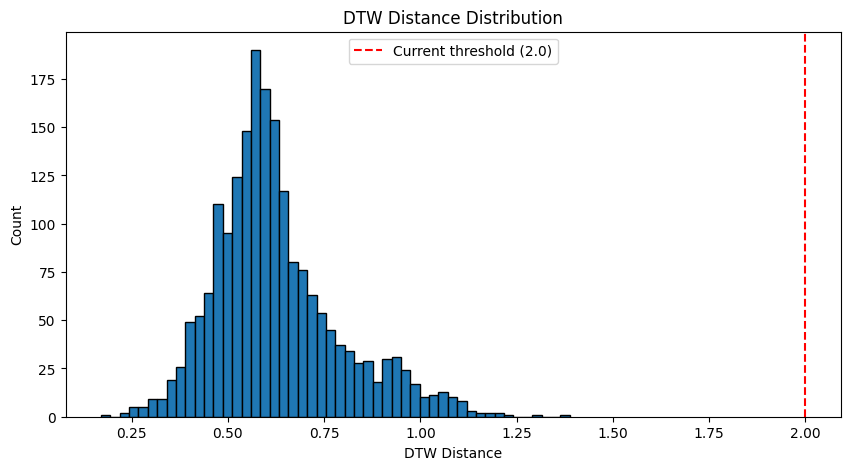

In [ ]:
# 1. 먼저 DTW 분포 확인
pairs_with_dtw_info = find_comovement_pairs(
    pivot,
    max_lag=9,
    min_nonzero=12,
    corr_threshold=0.4,
    score_threshold=35,
    use_dtw=True,
    dtw_threshold=999  # 일단 전부 통과시키고
)

# DTW 거리 분포 확인
print("=== DTW Distance 분포 ===")
print(pairs_with_dtw_info['dtw_distance'].describe())
print(f"\n25th percentile: {pairs_with_dtw_info['dtw_distance'].quantile(0.25)}")
print(f"50th percentile (median): {pairs_with_dtw_info['dtw_distance'].quantile(0.50)}")
print(f"75th percentile: {pairs_with_dtw_info['dtw_distance'].quantile(0.75)}")

# 히스토그램으로 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.hist(pairs_with_dtw_info['dtw_distance'], bins=50, edgecolor='black')
plt.xlabel('DTW Distance')
plt.ylabel('Count')
plt.title('DTW Distance Distribution')
plt.axvline(x=2.0, color='r', linestyle='--', label='Current threshold (2.0)')
plt.legend()
plt.show()

상관계수(corr_threshold=0.3)를 통과한 쌍들의 dtw분포, 즉 패턴 유사도를 보여줌



---



In [8]:
import os
import datetime

# result 폴더 생성 (이미 있으면 무시)
os.makedirs('./result', exist_ok=True)
date_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

# 파일 저장
file_name = f'./result/sy_{date_str}.csv'
submission.to_csv(file_name, index=False)

In [16]:
import datetime
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from tqdm import tqdm

train = pd.read_csv('/content/drive/MyDrive/국민대_무역_공모전/데이터/train.csv')

# --- 데이터 전처리 (변경 없음) ---
monthly = (
    train
    .groupby(["item_id", "year", "month"], as_index=False)["value"]
    .sum()
)
monthly["ym"] = pd.to_datetime(
    monthly["year"].astype(str) + "-" + monthly["month"].astype(str).str.zfill(2)
)
pivot = (
    monthly
    .pivot(index="item_id", columns="ym", values="value")
    .fillna(0.0)
)
months_dt = pivot.columns.to_list() # 월(datetime) 리스트

# [중요] 원본 pivot을 사용. S1(F1) 점수를 위해 corr_threshold를 튜닝해야 함.
print("--- '원본 값' 기반 공행성 쌍 탐색 시작 ---")
pairs = pairs_with_dtw

print("탐색된 공행성쌍 수:", len(pairs))


# --- (2. 학습 데이터 구축 - [수정됨] 피처 엔지니어링) ---
def build_training_data_optimized(pivot, pairs, months_dt):
    """추가 고급 피처 5개 포함"""
    months = months_dt
    n_months = len(months)
    rows = []

    for row in pairs.itertuples(index=False):
        leader = row.leading_item_id
        follower = row.following_item_id
        lag = int(row.best_lag)
        corr = float(row.max_corr)

        if leader not in pivot.index or follower not in pivot.index:
            continue

        a_series = pivot.loc[leader].values.astype(float)
        b_series = pivot.loc[follower].values.astype(float)

        for t in range(max(lag, 12), n_months - 1):
            b_t = b_series[t]
            b_t_1 = b_series[t - 1]
            b_t_2 = b_series[t - 2]
            b_t_12 = b_series[t - 12]
            a_t_lag = a_series[t - lag]
            b_t_plus_1 = b_series[t + 1]

            target_month = months[t + 1].month

            # === 핵심 피처들 ===

            # 1. 선행 품목(A) 트렌드
            a_t_lag_diff = a_series[t - lag] - a_series[t - lag - 1]
            a_momentum = a_series[t - lag] / (a_series[t - lag - 3] + 1)
            a_roll_mean_3 = (a_series[t-lag] + a_series[t-lag-1] + a_series[t-lag-2]) / 3

            # 2. 후행 품목(B) 트렌드
            b_diff = b_t - b_t_1
            b_pct_change = (b_t - b_t_1) / (b_t_1 + 1)
            b_yoy_growth = (b_t - b_t_12) / (b_t_12 + 1)
            b_roll_mean_3 = (b_series[t] + b_series[t-1] + b_series[t-2]) / 3
            b_roll_mean_6 = (b_series[t-5:t+1]).mean()
            b_roll_std_3 = np.std([b_series[t], b_series[t-1], b_series[t-2]])

            # 3. A-B 상호작용
            ab_ratio = a_t_lag / (b_t + 1)
            ab_diff = a_t_lag - b_t
            corr_weighted_a = a_t_lag * corr

            # 4. 추가 고급 피처 (5개)
            # 4-1. 변동계수
            b_cv = b_roll_std_3 / (b_roll_mean_3 + 1)

            # 4-2. 가속도
            b_acceleration = (b_t - b_t_1) - (b_t_1 - b_t_2)

            # 4-3. 전년 동월 비율
            b_yoy_ratio = b_t / (b_t_12 + 1)

            # 4-4. MA 비율
            b_ma_ratio = b_roll_mean_3 / (b_roll_mean_6 + 1)

            # 4-5. 백분위 랭크
            recent_12 = b_series[max(0, t-11):t+1]
            b_percentile_rank = (b_t >= recent_12).sum() / len(recent_12)

            # 5. 계절성
            quarter = (target_month - 1) // 3 + 1
            is_year_end = 1 if target_month in [11, 12, 1] else 0

            # 6. Lag 가중치
            lag_weight = 1 / (1 + lag)

            rows.append({
                # 기존 기본 피처
                "b_t": b_t,
                "b_t_1": b_t_1,
                "b_t_12": b_t_12,
                "a_t_lag": a_t_lag,
                "max_corr": corr,
                "best_lag": float(lag),
                "month": float(target_month),

                # A 트렌드 (3개)
                "a_t_lag_diff": a_t_lag_diff,
                "a_momentum": a_momentum,
                "a_roll_mean_3": a_roll_mean_3,

                # B 트렌드 (6개)
                "b_diff": b_diff,
                "b_pct_change": b_pct_change,
                "b_yoy_growth": b_yoy_growth,
                "b_roll_mean_3": b_roll_mean_3,
                "b_roll_mean_6": b_roll_mean_6,
                "b_roll_std_3": b_roll_std_3,

                # 상호작용 (3개)
                "ab_ratio": ab_ratio,
                "ab_diff": ab_diff,
                "corr_weighted_a": corr_weighted_a,

                # 추가 고급 피처 (5개) ★ NEW ★
                "b_cv": b_cv,
                "b_acceleration": b_acceleration,
                "b_yoy_ratio": b_yoy_ratio,
                "b_ma_ratio": b_ma_ratio,
                "b_percentile_rank": b_percentile_rank,

                # 계절성 (2개)
                "quarter": float(quarter),
                "is_year_end": is_year_end,

                # Lag (1개)
                "lag_weight": lag_weight,

                "target": b_t_plus_1,
            })

    return pd.DataFrame(rows)


df_train_model = build_training_data_optimized(pivot, pairs, months_dt)
print('생성된 학습 데이터의 shape :', df_train_model.shape)


# --- (3. 회귀모델 학습 - [수정됨] 피처 리스트) ---
# 피처 리스트 (총 28개)
feature_cols = [
    # 기본 (7개)
    'b_t', 'b_t_1', 'b_t_12', 'a_t_lag', 'max_corr', 'best_lag', 'month',

    # A 트렌드 (3개)
    'a_t_lag_diff', 'a_momentum', 'a_roll_mean_3',

    # B 트렌드 (6개)
    'b_diff', 'b_pct_change', 'b_yoy_growth',
    'b_roll_mean_3', 'b_roll_mean_6', 'b_roll_std_3',

    # 상호작용 (3개)
    'ab_ratio', 'ab_diff', 'corr_weighted_a',

    # 추가 고급 피처 (5개) ★ NEW ★
    'b_cv', 'b_acceleration', 'b_yoy_ratio', 'b_ma_ratio', 'b_percentile_rank',

    # 계절성 (2개)
    'quarter', 'is_year_end',

    # Lag (1개)
    'lag_weight'
]

if df_train_model.empty:
    print("오류: 학습 데이터가 없습니다. (lag가 너무 크거나, t 시작점이 높을 수 있음)")
    submission = pd.DataFrame(columns=['leading_item_id', 'following_item_id', 'value'])
else:
    train_X = df_train_model[feature_cols].values
    train_y = df_train_model["target"].values

    reg = LGBMRegressor(
    random_state=42,
    n_estimators=700,
    learning_rate=0.01,
    max_depth=8,
    num_leaves=50,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    min_split_gain=0.01
)
    print("LGBMRegressor 모델(고급 피처 추가) 학습 시작...")
    print(f"총 피처 개수: {len(feature_cols)}개")
    reg.fit(train_X, train_y)
    print("모델 학습 완료.")


# --- (4. 예측 - [수정됨] 피처 생성) ---
def predict_optimized(pivot, pairs, reg, months_dt):
    """고급 피처 포함 예측"""
    months = months_dt
    n_months = len(months)
    t_last = n_months - 1
    t_prev = n_months - 2
    preds = []

    target_month = months[-1].month + 1 if months[-1].month < 12 else 1

    for row in tqdm(pairs.itertuples(index=False)):
        leader = row.leading_item_id
        follower = row.following_item_id
        lag = int(row.best_lag)
        corr = float(row.max_corr)

        if leader not in pivot.index or follower not in pivot.index:
            continue

        a_series = pivot.loc[leader].values.astype(float)
        b_series = pivot.loc[follower].values.astype(float)

        if t_last - lag < 0 or t_last < 12:
            continue

        b_t = b_series[t_last]
        b_t_1 = b_series[t_prev]
        b_t_2 = b_series[t_prev - 1]
        b_t_12 = b_series[t_last - 12]
        a_t_lag = a_series[t_last - lag]

        # A 트렌드
        a_t_lag_diff = a_series[t_last - lag] - a_series[t_last - lag - 1]
        a_momentum = a_series[t_last - lag] / (a_series[t_last - lag - 3] + 1)
        a_roll_mean_3 = (a_series[t_last-lag] + a_series[t_last-lag-1] + a_series[t_last-lag-2]) / 3

        # B 트렌드
        b_diff = b_t - b_t_1
        b_pct_change = (b_t - b_t_1) / (b_t_1 + 1)
        b_yoy_growth = (b_t - b_t_12) / (b_t_12 + 1)
        b_roll_mean_3 = (b_series[t_last] + b_series[t_last-1] + b_series[t_last-2]) / 3
        b_roll_mean_6 = b_series[t_last-5:t_last+1].mean()
        b_roll_std_3 = np.std([b_series[t_last], b_series[t_last-1], b_series[t_last-2]])

        # 상호작용
        ab_ratio = a_t_lag / (b_t + 1)
        ab_diff = a_t_lag - b_t
        corr_weighted_a = a_t_lag * corr

        # 추가 고급 피처 (5개) ★ NEW ★
        b_cv = b_roll_std_3 / (b_roll_mean_3 + 1)
        b_acceleration = (b_t - b_t_1) - (b_t_1 - b_t_2)
        b_yoy_ratio = b_t / (b_t_12 + 1)
        b_ma_ratio = b_roll_mean_3 / (b_roll_mean_6 + 1)
        recent_12 = b_series[max(0, t_last-11):t_last+1]
        b_percentile_rank = (b_t >= recent_12).sum() / len(recent_12)

        # 계절성
        quarter = (target_month - 1) // 3 + 1
        is_year_end = 1 if target_month in [11, 12, 1] else 0

        # Lag
        lag_weight = 1 / (1 + lag)

        X_test = np.array([[
            b_t, b_t_1, b_t_12, a_t_lag, corr, float(lag), float(target_month),
            a_t_lag_diff, a_momentum, a_roll_mean_3,
            b_diff, b_pct_change, b_yoy_growth, b_roll_mean_3, b_roll_mean_6, b_roll_std_3,
            ab_ratio, ab_diff, corr_weighted_a,
            b_cv, b_acceleration, b_yoy_ratio, b_ma_ratio, b_percentile_rank,
            float(quarter), is_year_end,
            lag_weight
        ]])

        y_pred = reg.predict(X_test)[0]
        y_pred = max(0.0, float(y_pred))
        y_pred = int(round(y_pred))

        preds.append({
            "leading_item_id": leader,
            "following_item_id": follower,
            "value": y_pred,
        })

    return pd.DataFrame(preds)

if df_train_model.empty:
    print("학습된 모델이 없어 예측을 건너뜁니다.")
else:
    print("--- '고급 피처 추가' 모델 예측 시작 ---")
    submission = predict_optimized(pivot, pairs, reg, months_dt)
    print(submission.head())

date_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
file_name = f'./result/sy_advanced_{date_str}.csv'
submission.to_csv(file_name, index=False)


print(f"✓ 파일 저장 완료: {file_name}")
print(f"LGBM(고급 피처 추가) 모델 예측 완료. {file_name}.csv 저장됨.")

--- '원본 값' 기반 공행성 쌍 탐색 시작 ---
탐색된 공행성쌍 수: 3368
생성된 학습 데이터의 shape : (101040, 28)
LGBMRegressor 모델(고급 피처 추가) 학습 시작...
총 피처 개수: 27개
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5408
[LightGBM] [Info] Number of data points in the train set: 101040, number of used features: 27
[LightGBM] [Info] Start training from score 4144408.771546
모델 학습 완료.
--- '고급 피처 추가' 모델 예측 시작 ---


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/pyth

  leading_item_id following_item_id     value
0        AANGBULD          ZCELVYQU    198935
1        AANGBULD          ZKENOUDA    331376
2        AANGBULD          DEWLVASR    337475
3        AANGBULD          NAQIHUKZ     45688
4        AANGBULD          GKQIJYDH  12552882
✓ 파일 저장 완료: ./result/sy_advanced_20251120_075236.csv
LGBM(고급 피처 추가) 모델 예측 완료. ./result/sy_advanced_20251120_075236.csv.csv 저장됨.


In [ ]:
# import datetime
# import pandas as pd
# import numpy as np
# from sklearn.linear_model import LinearRegression
# from lightgbm import LGBMRegressor
# from tqdm import tqdm

# train = pd.read_csv('/content/drive/MyDrive/국민대_무역_공모전/데이터/train.csv')

# # --- 데이터 전처리 (변경 없음) ---
# monthly = (
#     train
#     .groupby(["item_id", "year", "month"], as_index=False)["value"]
#     .sum()
# )
# monthly["ym"] = pd.to_datetime(
#     monthly["year"].astype(str) + "-" + monthly["month"].astype(str).str.zfill(2)
# )
# pivot = (
#     monthly
#     .pivot(index="item_id", columns="ym", values="value")
#     .fillna(0.0)
# )
# months_dt = pivot.columns.to_list() # 월(datetime) 리스트

# # [중요] 원본 pivot을 사용. S1(F1) 점수를 위해 corr_threshold를 튜닝해야 함.
# print("--- '원본 값' 기반 공행성 쌍 탐색 시작 ---")
# pairs = find_comovement_pairs(pivot, corr_threshold=0.3)

# pairs = pairs_with_dtw
# print("탐색된 공행성쌍 수:", len(pairs))


# # --- (2. 학습 데이터 구축 - [수정됨] 피처 엔지니어링) ---
# def build_training_data(pivot, pairs, months_dt):
#     months = months_dt
#     n_months = len(months)
#     rows = []

#     for row in pairs.itertuples(index=False):
#         leader = row.leading_item_id
#         follower = row.following_item_id
#         lag = int(row.best_lag)
#         corr = float(row.max_corr)
#         if leader not in pivot.index or follower not in pivot.index:
#             continue
#         a_series = pivot.loc[leader].values.astype(float)
#         b_series = pivot.loc[follower].values.astype(float)

#         # [수정] 1년(12개월)치 피처를 사용하기 위해 t의 시작점을 12부터로 변경
#         for t in range(max(lag, 12), n_months - 1):
#             b_t = b_series[t]
#             b_t_1 = b_series[t - 1]
#             a_t_lag = a_series[t - lag]
#             b_t_plus_1 = b_series[t + 1]

#             # [새 피처 1] B의 1년 전 동월 값
#             b_t_12 = b_series[t - 12]

#             # [새 피처 2] B의 3개월 롤링 평균
#             b_roll_mean_3 = (b_series[t] + b_series[t-1] + b_series[t-2]) / 3

#             # [새 피처 3] 예측할 달 (t+1)의 월(month) 정보 (계절성)
#             target_month = months[t + 1].month

#             rows.append({
#                 "b_t": b_t,
#                 "b_t_1": b_t_1,
#                 "a_t_lag": a_t_lag,
#                 "max_corr": corr,
#                 "best_lag": float(lag),
#                 "b_t_12": b_t_12,             # <-- 추가
#                 "b_roll_mean_3": b_roll_mean_3, # <-- 추가
#                 "month": float(target_month), # <-- 추가
#                 "target": b_t_plus_1,
#             })
#     df_train = pd.DataFrame(rows)
#     return df_train

# df_train_model = build_training_data(pivot, pairs, months_dt)
# print('생성된 학습 데이터의 shape :', df_train_model.shape)


# # --- (3. 회귀모델 학습 - [수정됨] 피처 리스트) ---
# # [수정] 5개 -> 8개 피처로 변경
# feature_cols = [
#     'b_t', 'b_t_1', 'a_t_lag', 'max_corr', 'best_lag',
#     'b_t_12', 'b_roll_mean_3', 'month' # <-- 추가
# ]

# if df_train_model.empty:
#     print("오류: 학습 데이터가 없습니다. (lag가 너무 크거나, t 시작점이 높을 수 있음)")
#     submission = pd.DataFrame(columns=['leading_item_id', 'following_item_id', 'value'])
# else:
#     train_X = df_train_model[feature_cols].values
#     train_y = df_train_model["target"].values

#     reg = LGBMRegressor(random_state=42, n_estimators=500, learning_rate= 0.01)
#     print("LGBMRegressor 모델(피처 추가) 학습 시작...")
#     reg.fit(train_X, train_y)
#     print("모델 학습 완료.")


# # --- (4. 예측 - [수정됨] 피처 생성) ---
# def predict(pivot, pairs, reg, months_dt):
#     months = months_dt
#     n_months = len(months)
#     t_last = n_months - 1
#     t_prev = n_months - 2
#     preds = []

#     # 예측할 달(2025년 8월)의 '월' 정보
#     target_month = months[-1].month + 1 if months[-1].month < 12 else 1

#     for row in tqdm(pairs.itertuples(index=False)):
#         leader = row.leading_item_id
#         follower = row.following_item_id
#         lag = int(row.best_lag)
#         corr = float(row.max_corr)
#         if leader not in pivot.index or follower not in pivot.index:
#             continue
#         a_series = pivot.loc[leader].values.astype(float)
#         b_series = pivot.loc[follower].values.astype(float)

#         # [수정] 12개월치 피처를 쓰기 위해 t_last가 12보다 큰지 확인
#         if t_last - lag < 0 or t_last < 12:
#             continue

#         b_t = b_series[t_last]
#         b_t_1 = b_series[t_prev]
#         a_t_lag = a_series[t_last - lag]

#         # [새 피처]
#         b_t_12 = b_series[t_last - 12]
#         b_roll_mean_3 = (b_series[t_last] + b_series[t_last-1] + b_series[t_last-2]) / 3

#         # [수정] 8개 피처로 X_test 구성
#         X_test = np.array([[
#             b_t, b_t_1, a_t_lag, corr, float(lag),
#             b_t_12, b_roll_mean_3, float(target_month) # <-- 추가
#         ]])

#         y_pred = reg.predict(X_test)[0]

#         y_pred = max(0.0, float(y_pred))
#         y_pred = int(round(y_pred))

#         preds.append({
#             "leading_item_id": leader,
#             "following_item_id": follower,
#             "value": y_pred,
#         })
#     df_pred = pd.DataFrame(preds)
#     return df_pred

# if df_train_model.empty:
#     print("학습된 모델이 없어 예측을 건너뜁니다.")
# else:
#     print("--- '피처 추가' 모델 예측 시작 ---")
#     submission = predict(pivot, pairs, reg, months_dt)
#     print(submission.head())

# date_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
# file_name = f'./result/sy_{date_str}.csv'
# submission.to_csv(file_name, index=False)


# print(f"✓ 파일 저장 완료: {file_name}")
# print(f"LGBM(원본, 피처추가) 모델 예측 완료. {file_name}.csv 저장됨.")

--- '원본 값' 기반 공행성 쌍 탐색 시작 ---


Finding pairs: 100%|██████████| 100/100 [00:55<00:00,  1.82it/s]


탐색된 공행성쌍 수: 3368
생성된 학습 데이터의 shape : (101040, 9)
LGBMRegressor 모델(피처 추가) 학습 시작...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002914 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1553
[LightGBM] [Info] Number of data points in the train set: 101040, number of used features: 8
[LightGBM] [Info] Start training from score 4144408.771546
모델 학습 완료.
--- '피처 추가' 모델 예측 시작 ---


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/pyth

  leading_item_id following_item_id    value
0        AANGBULD          ZCELVYQU   200814
1        AANGBULD          ZKENOUDA   352609
2        AANGBULD          DEWLVASR   348462
3        AANGBULD          NAQIHUKZ   125379
4        AANGBULD          GKQIJYDH  8486755
✓ 파일 저장 완료: ./result/sy_20251118_113340.csv
LGBM(원본, 피처추가) 모델 예측 완료. ./result/sy_20251118_113340.csv.csv 저장됨.


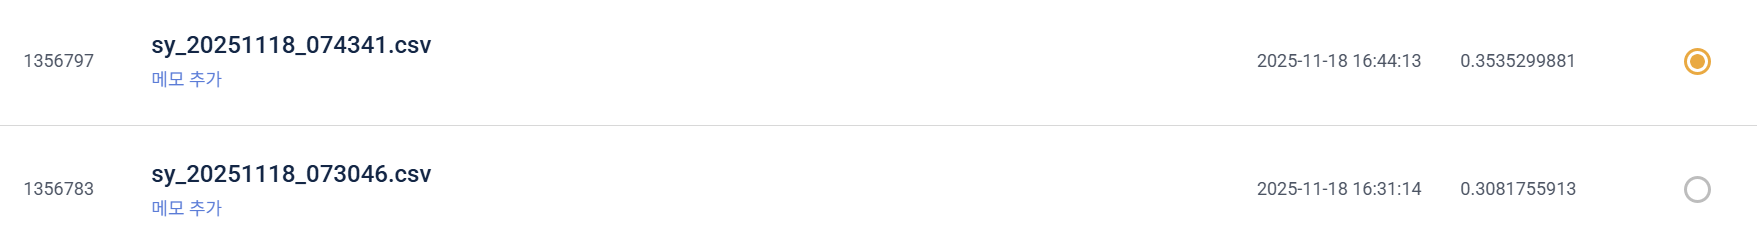

dtw_threshold를 0.7에서 1.0으로 바꿨을 때 급격히 오르고, 1.0->1.25로 올렸을 땐 0.35352 -> 0.35374로 미미함

최고성능은 현재 상태로, 0.3592932451



---



---



---



=== Feature Importance (LightGBM) ===
            feature  importance
0               b_t        2036
14    b_roll_mean_6        1767
6             month        1621
12     b_yoy_growth        1612
2            b_t_12        1569
1             b_t_1        1459
15     b_roll_std_3        1388
13    b_roll_mean_3        1321
10           b_diff        1267
11     b_pct_change         907
20      is_year_end          53
5          best_lag           0
3           a_t_lag           0
4          max_corr           0
8        a_momentum           0
7      a_t_lag_diff           0
9     a_roll_mean_3           0
16         ab_ratio           0
17          ab_diff           0
18  corr_weighted_a           0
19          quarter           0
21       lag_weight           0


/tmp/ipython-input-2381325172.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance, x='importance', y='feature', palette='viridis')


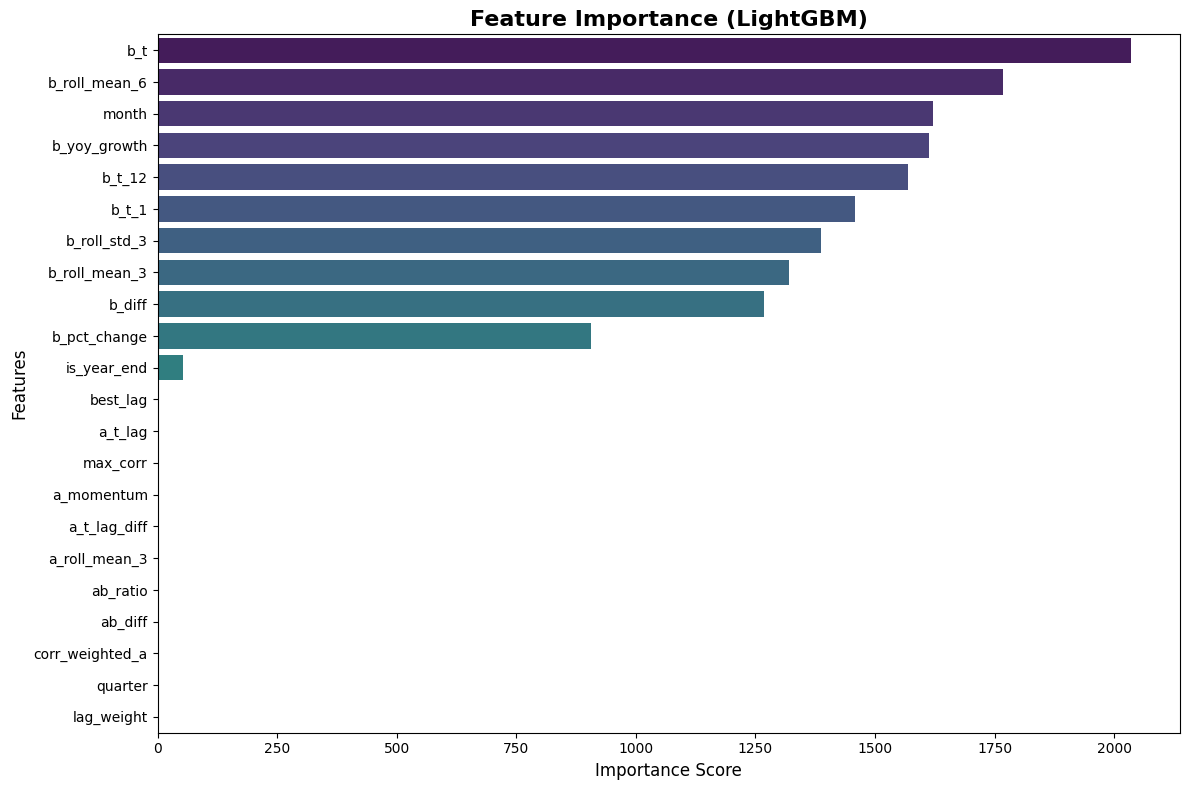

/tmp/ipython-input-2381325172.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10, x='importance', y='feature', palette='rocket')


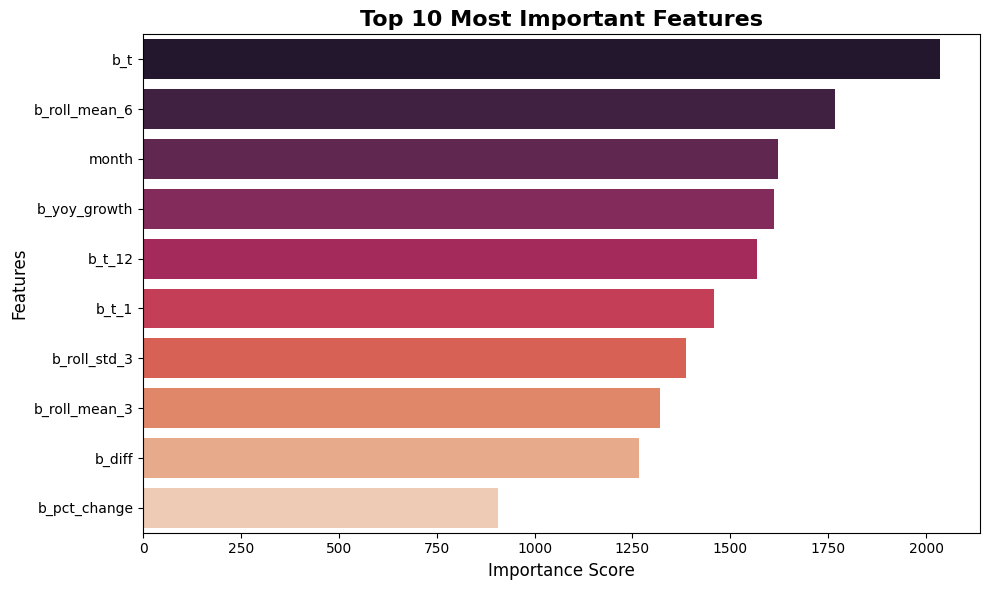


=== Feature Group Importance ===
         group  total_importance
1      B_trend             13326
3  Seasonality              1674
0      A_trend                 0
2  Interaction                 0
4          Lag                 0


/tmp/ipython-input-2381325172.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=group_df, x='total_importance', y='group', palette='mako')


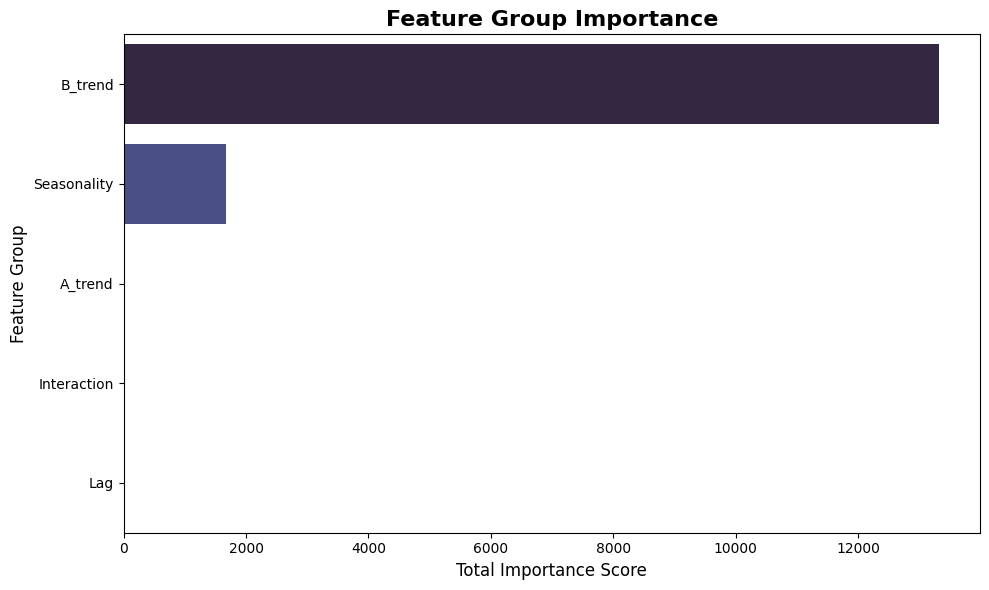


=== Feature Importance Statistics ===
평균 중요도: 681.8182
중앙값 중요도: 26.5000
표준편차: 785.5623

상위 5개 피처가 차지하는 비율: 57.37%
상위 10개 피처가 차지하는 비율: 99.65%


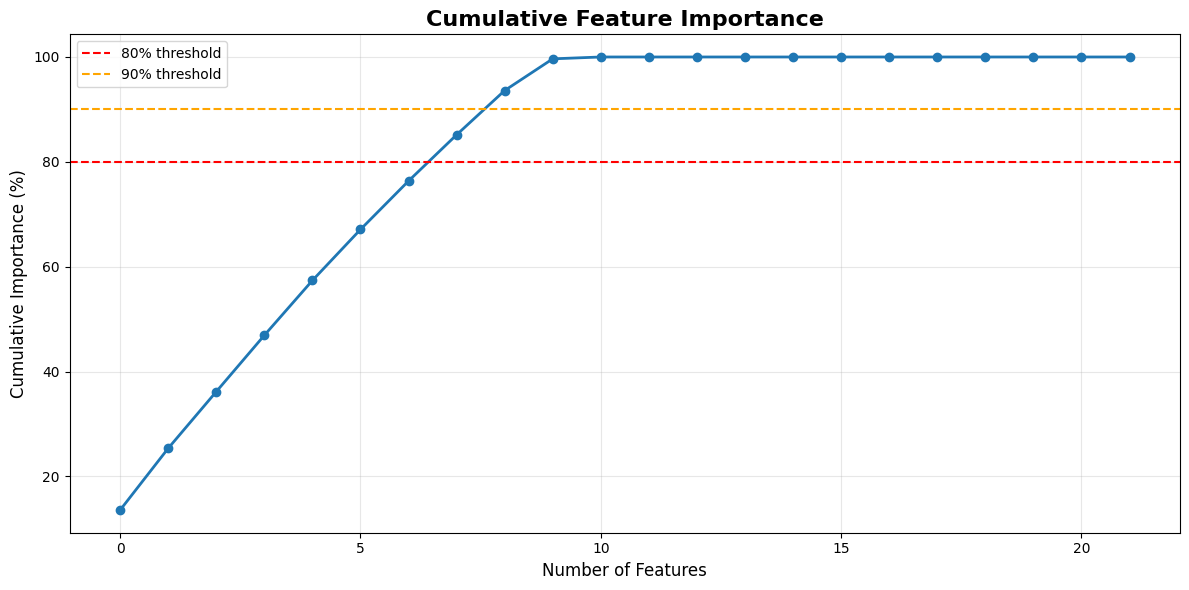


중요도 80% 달성하는 피처 개수: 8개
중요도 90% 달성하는 피처 개수: 9개

=== Permutation Importance 계산 중... (시간 소요) ===


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



=== Permutation Importance ===
          feature  importance_mean  importance_std
13  b_roll_mean_3         0.838512        0.010979
2          b_t_12         0.102981        0.001505
14  b_roll_mean_6         0.086762        0.000885
0             b_t         0.080491        0.000614
6           month         0.013384        0.000644
1           b_t_1         0.011770        0.000125
12   b_yoy_growth         0.011508        0.000337
15   b_roll_std_3         0.009368        0.000189
11   b_pct_change         0.007817        0.000497
10         b_diff         0.004652        0.000112
20    is_year_end         0.000180        0.000021
5        best_lag         0.000000        0.000000
3         a_t_lag         0.000000        0.000000
4        max_corr         0.000000        0.000000
8      a_momentum         0.000000        0.000000


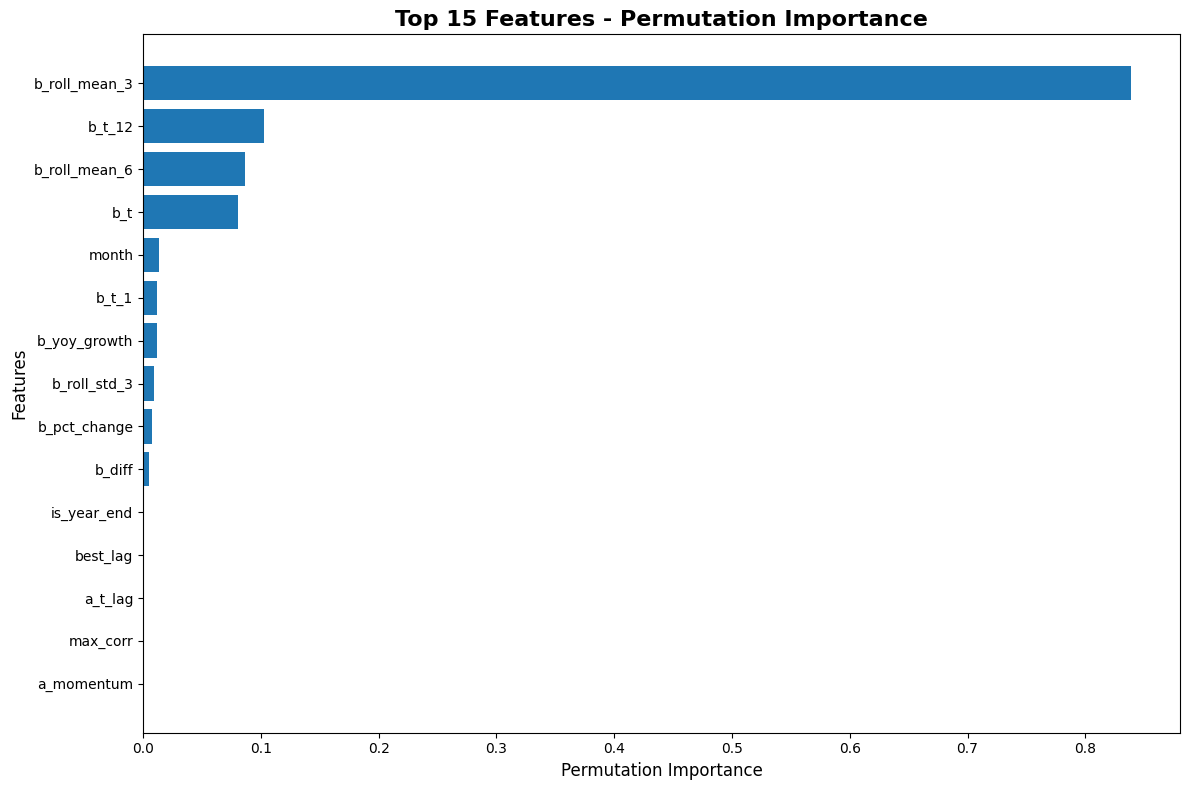


=== LightGBM vs Permutation Importance 비교 ===


KeyError: 'importance_lgbm'

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# ===== 1. LightGBM Feature Importance 추출 =====
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': reg.feature_importances_
}).sort_values('importance', ascending=False)

print("=== Feature Importance (LightGBM) ===")
print(feature_importance)

# ===== 2. 시각화 =====
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance, x='importance', y='feature', palette='viridis')
plt.title('Feature Importance (LightGBM)', fontsize=16, fontweight='bold')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.tight_layout()
plt.show()

# ===== 3. 상위 10개 피처만 표시 =====
plt.figure(figsize=(10, 6))
top_10 = feature_importance.head(10)
sns.barplot(data=top_10, x='importance', y='feature', palette='rocket')
plt.title('Top 10 Most Important Features', fontsize=16, fontweight='bold')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.tight_layout()
plt.show()

# ===== 4. 피처 그룹별 중요도 합계 =====
feature_groups = {
    'A_trend': ['a_t_lag', 'a_t_lag_diff', 'a_momentum', 'a_roll_mean_3'],
    'B_trend': ['b_t', 'b_t_1', 'b_t_12', 'b_diff', 'b_pct_change', 'b_yoy_growth',
                'b_roll_mean_3', 'b_roll_mean_6', 'b_roll_std_3'],
    'Interaction': ['ab_ratio', 'ab_diff', 'corr_weighted_a', 'max_corr'],
    'Seasonality': ['month', 'quarter', 'is_year_end'],
    'Lag': ['best_lag', 'lag_weight']
}

group_importance = {}
for group_name, features in feature_groups.items():
    total_importance = feature_importance[
        feature_importance['feature'].isin(features)
    ]['importance'].sum()
    group_importance[group_name] = total_importance

group_df = pd.DataFrame({
    'group': list(group_importance.keys()),
    'total_importance': list(group_importance.values())
}).sort_values('total_importance', ascending=False)

print("\n=== Feature Group Importance ===")
print(group_df)

# 그룹별 중요도 시각화
plt.figure(figsize=(10, 6))
sns.barplot(data=group_df, x='total_importance', y='group', palette='mako')
plt.title('Feature Group Importance', fontsize=16, fontweight='bold')
plt.xlabel('Total Importance Score', fontsize=12)
plt.ylabel('Feature Group', fontsize=12)
plt.tight_layout()
plt.show()

# ===== 5. 피처 중요도 통계 요약 =====
print("\n=== Feature Importance Statistics ===")
print(f"평균 중요도: {feature_importance['importance'].mean():.4f}")
print(f"중앙값 중요도: {feature_importance['importance'].median():.4f}")
print(f"표준편차: {feature_importance['importance'].std():.4f}")
print(f"\n상위 5개 피처가 차지하는 비율: {feature_importance.head(5)['importance'].sum() / feature_importance['importance'].sum() * 100:.2f}%")
print(f"상위 10개 피처가 차지하는 비율: {feature_importance.head(10)['importance'].sum() / feature_importance['importance'].sum() * 100:.2f}%")

# ===== 6. 누적 중요도 그래프 =====
feature_importance_sorted = feature_importance.sort_values('importance', ascending=False).reset_index(drop=True)
feature_importance_sorted['cumulative'] = feature_importance_sorted['importance'].cumsum() / feature_importance_sorted['importance'].sum() * 100

plt.figure(figsize=(12, 6))
plt.plot(range(len(feature_importance_sorted)), feature_importance_sorted['cumulative'], marker='o', linewidth=2)
plt.axhline(y=80, color='r', linestyle='--', label='80% threshold')
plt.axhline(y=90, color='orange', linestyle='--', label='90% threshold')
plt.xlabel('Number of Features', fontsize=12)
plt.ylabel('Cumulative Importance (%)', fontsize=12)
plt.title('Cumulative Feature Importance', fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# 80%, 90% 도달하는 피처 개수
n_features_80 = (feature_importance_sorted['cumulative'] <= 80).sum() + 1
n_features_90 = (feature_importance_sorted['cumulative'] <= 90).sum() + 1
print(f"\n중요도 80% 달성하는 피처 개수: {n_features_80}개")
print(f"중요도 90% 달성하는 피처 개수: {n_features_90}개")

# ===== 7. Permutation Importance (선택사항 - 시간 오래 걸림) =====
print("\n=== Permutation Importance 계산 중... (시간 소요) ===")
from sklearn.inspection import permutation_importance

# 샘플링해서 빠르게 계산 (전체 데이터 사용 시 시간 오래 걸림)
sample_size = min(10000, len(train_X))
sample_indices = np.random.choice(len(train_X), sample_size, replace=False)
X_sample = train_X[sample_indices]
y_sample = train_y[sample_indices]

perm_importance = permutation_importance(
    reg, X_sample, y_sample,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

perm_importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance_mean': perm_importance.importances_mean,
    'importance_std': perm_importance.importances_std
}).sort_values('importance_mean', ascending=False)

print("\n=== Permutation Importance ===")
print(perm_importance_df.head(15))

# Permutation Importance 시각화
plt.figure(figsize=(12, 8))
top_15_perm = perm_importance_df.head(15)
plt.barh(range(len(top_15_perm)), top_15_perm['importance_mean'])
plt.yticks(range(len(top_15_perm)), top_15_perm['feature'])
plt.xlabel('Permutation Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Top 15 Features - Permutation Importance', fontsize=16, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# ===== 8. 두 중요도 비교 =====
comparison_df = feature_importance.merge(
    perm_importance_df[['feature', 'importance_mean']],
    on='feature',
    suffixes=('_lgbm', '_perm')
)

print("\n=== LightGBM vs Permutation Importance 비교 ===")
print(comparison_df.sort_values('importance_lgbm', ascending=False).head(15))